In [4]:
using DataFrames
using PythonPlot
using Statistics
using CSV
using JLD2
include("MDPModelFunctions2.jl")

sim_cowan_att (generic function with 1 method)

In [5]:
# read in retrocue_E1_clean.csv
data = CSV.read("retrocue_E1_clean.csv", DataFrame)
first(data,6)

Row,Column1,Subject,trial.number,Observation.id,food.loc,distract.loc,n_searches,delay,load,baiting,interval,first.search.time,first.search.loc,time.to.search,first.search,food.loc.row,food.loc.col,first.search.row,first.search.col
,Int64,String7,Int64,String31,String3,String7,Int64,String1,Int64,Float64,Float64,Float64,String3,Float64,Int64,String1,Int64,String1,Int64
1,1,Alba,1,Alba_E1_S1_T1,C2,None,1,M,1,35.24,10.88,47.64,C2,12.4,1,C,2,C,2
2,2,Alba,10,Alba_E1_S2_T3-4,E1,B1,2,L,2,92.12,10.96,104.48,E3,12.36,0,E,1,E,3
3,3,Alba,11,Alba_E1_S2_T5-6,B3,E2,3,M,2,53.32,10.32,66.24,B1,12.92,0,B,3,B,1
4,4,Alba,12,Alba_E1_S2_T5-6,F1,C2,1,S,2,112.64,7.12,125.04,F1,12.4,1,F,1,F,1
5,5,Alba,13,Alba_E1_S3_T1-6,D2,None,2,M,1,21.72,8.04,32.4,D3,10.68,0,D,2,D,3
6,6,Alba,14,Alba_E1_S3_T1-6,F1,None,3,S,1,66.84,6.76,75.56,F3,8.72,0,F,1,F,3


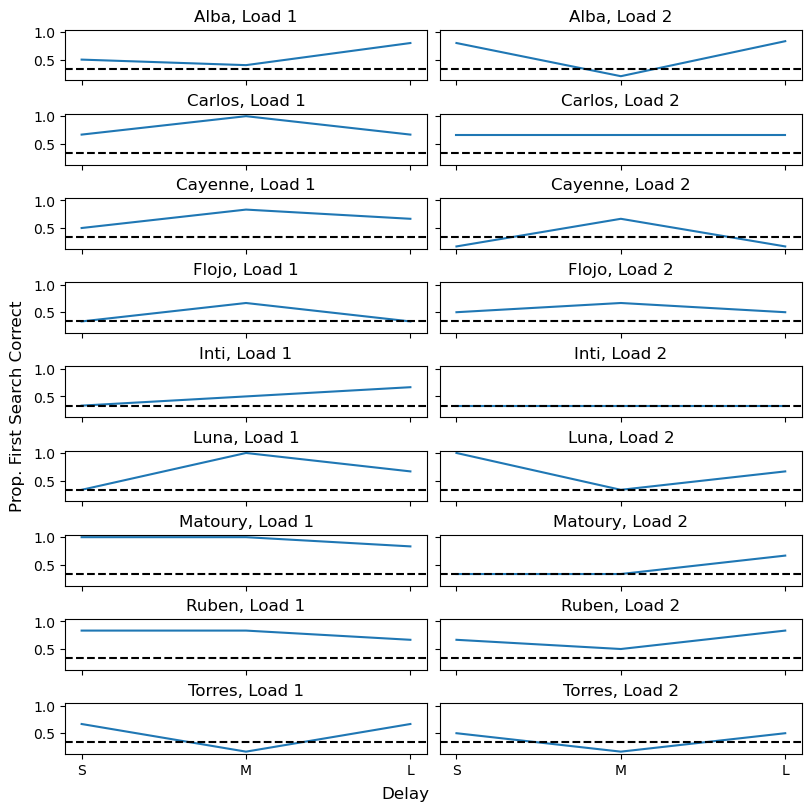

Python: Text(0.5, 0.00520875, 'Delay')

In [6]:

nsubj = length(unique(data[!,:Subject])) # 9 subjects
grouped_df = combine(groupby(data, [:delay, :load, :Subject]), Symbol("first.search") => mean => :mean_n_searches)

using CategoricalArrays

# Ensure the delay column is a categorical variable with specified order
grouped_df.delay = categorical(grouped_df.delay, levels=["S", "M", "L"], ordered=true)


subjects = unique(grouped_df.Subject)
delays = ["S", "M", "L"]
N_delays = length(delays)
loads = [1, 2]
N_loads = length(loads)
colors = Dict(subjects .=> range(0, stop=1, length=length(subjects)))  # Different color for each subject
markers = Dict(1 => "o", 2 => "s")  # Different markers for each load

fig,ax = subplots(nsubj, N_loads, sharey = true, sharex = true, figsize=(8, 8), constrained_layout=true)

subj = subjects[1]

for (s_idx, subj) in enumerate(subjects)
    subj_data = grouped_df[grouped_df.Subject .== subj, :]

    for i in 1:N_loads
        # i = 1
        load = loads[i]
        load_data = subj_data[subj_data.load .== load, :]

        # Sort the load_data dataframe based on delay order
        load_data = sort(load_data, :delay)

        load_delays = convert(Vector{String}, string.(load_data.delay))
        ax[s_idx-1, i-1].plot(load_delays, load_data.mean_n_searches)
        ax[s_idx-1, i-1].set_title("$subj, Load $load")

        # plot a dashed horzontal line at .3333
        ax[s_idx-1, i-1].axhline(y=1/3, color="black", linestyle="--")
    end
end
fig.supylabel("Prop. First Search Correct")
fig.supxlabel("Delay")


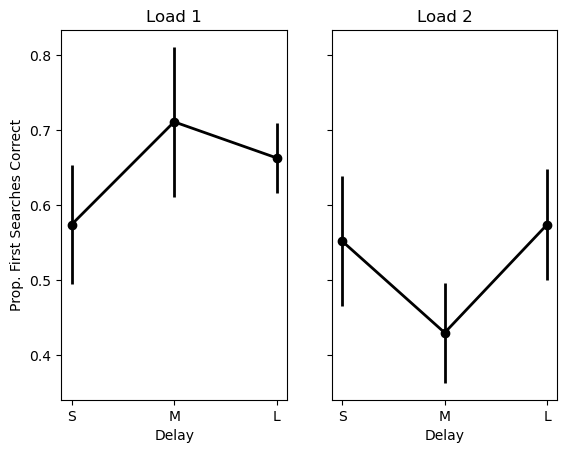

Python: Text(24.000000000000014, 0.5, 'Prop. First Searches Correct')

In [7]:
# take the mean of grouped_df accross subjects
mean_grouped_df = combine(groupby(grouped_df, [:delay, :load]), :mean_n_searches => mean => :mean_n_searches)
# also compute the standard error of the mean
sem(x) = std(x) / sqrt(length(x))
sem_grouped_df = combine(groupby(grouped_df, [:delay, :load]), :mean_n_searches => sem => :sem_n_searches)

fig,ax = subplots(1, N_loads, sharey = true)

for i in 1:N_loads
    load = loads[i]
    load_data = mean_grouped_df[mean_grouped_df.load .== load, :]

    load_delays = convert(Vector{String}, string.(load_data.delay))

    # plot mean with error bars for sem
    ax[i-1].errorbar(load_delays, load_data.mean_n_searches, yerr=sem_grouped_df[sem_grouped_df.load .== load, :sem_n_searches], fmt="-o", color="black", linewidth=2)

    # ax[i-1].plot(load_delays, load_data.mean_n_searches, "-o", color="black", linewidth=2)
    ax[i-1].set_title("Load $load")
    ax[i-1].set_xlabel("Delay")
end
ax[0].set_ylabel("Prop. First Searches Correct")



In [8]:
mean_grouped_df

# make a matrix of mean_n_searches for each load X delay (row should be load 1 then load 2); delay should be S, M, L
mean_perf_data = reshape(mean_grouped_df.mean_n_searches, N_loads, N_delays)

# structure this in the same way that the simulations are saved...

2×3 Matrix{Float64}:
 0.574074  0.711111  0.662963
 0.551852  0.42963   0.574074

In [9]:
# load the results for each parameter combination run...
# list all conditions we want to run
N_Object_Vals = [2, 3]; # this is just 2 and 3, but in practice, it is 1 and 2
N_Seconds_NoCue = [5,7,10]

# parameter values...
NT_vals = [50,100,200,400]#[800]#[25, 50, 100, 200, 400, 800]
# set parameters for each job... 
eps_vals = collect(1:-.02:.01) # 17

# quanta values - could be more fine-grained...
q_vals = collect(2:2:50) #

# memory slopes
mem_slopes = [.05, .1, .2, .4]

4-element Vector{Float64}:
 0.05
 0.1
 0.2
 0.4

In [10]:
# Create list of all parameter combinations
function create_parameter_list(eps_vals, q_vals, NT_vals, mem_slopes)
    all_params = []
    
    for epsilon in eps_vals
        for N_Quanta in q_vals
            for NT_per_Second in NT_vals
                for mem_slope in mem_slopes
                    push!(all_params, Dict(
                        "epsilon" => epsilon,
                        "N_Quanta" => Int(N_Quanta),
                        "NT_per_Second" => Int(NT_per_Second),
                        "mem_slope" => mem_slope
                    ))
                end
            end
        end
    end
    
    return all_params
end


function load_results(N_Quanta, epsilon, NT_per_Second; res_part = "delayed_memory")

    # res_part should either be "delayed_memory" or "retrocue"

    res_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Data/Memory_Models/monkey_sims"
    
    file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_$(NT_per_Second).jld2"

    full_file_path = joinpath(res_folder, res_part, file_name)

    results = load(full_file_path)
    
    return results

end


# function to load delay_prob_correct and retro_cue_prob_correct
function load_prob_correct(N_Quanta, epsilon, NT_per_Second)

    # load delayed memory results
    these_res = load_results(N_Quanta, epsilon, NT_per_Second, res_part = "delayed_memory")

    # N_Obj X N_Sec, N_Memslopes - delay_prob_correct
    delay_prob_correct = these_res["delay_prob_correct"]

    return delay_prob_correct

end

# Function to load a single data point and turn it into a feature and target vector
function load_data_point(params)
    delay_prob = load_prob_correct(
        params["N_Quanta"],
        params["epsilon"],
        params["NT_per_Second"]
    )

    mem_slopes = [.05, .1, .2, .4]
    mem_slope_idx = findfirst(x -> isapprox(x, params["mem_slope"], rtol=1e-10), mem_slopes)
    
    if isnothing(mem_slope_idx)
        error("Invalid mem_slope value: $(params["mem_slope"])")
    end
    
    # Extract and flatten features
    delay_features = delay_prob[:, :, mem_slope_idx]
    
    return delay_features
end



load_data_point (generic function with 1 method)

In [11]:
# function to load delay_prob_correct and retro_cue_prob_correct
these_params = Dict(
    "N_Quanta" => 10,
    "epsilon" => .1,
    "NT_per_Second" => 200,
    "mem_slope" => .1
)

load_prob_correct(10, .1, 200)


2×3×4 Array{Float64, 3}:
[:, :, 1] =
 0.478894  0.479025  0.477929
 0.435153  0.434223  0.433996

[:, :, 2] =
 0.589501  0.589665  0.587989
 0.518449  0.516867  0.516277

[:, :, 3] =
 0.738426  0.738523  0.736561
 0.642523  0.640191  0.638678

[:, :, 4] =
 0.879252  0.879161  0.877813
 0.784098  0.78138   0.777987

In [12]:
# load all data points...
param_list = create_parameter_list(eps_vals, q_vals, NT_vals, mem_slopes)
param_df = DataFrame(param_list)

N_params = size(param_df, 1)

all_data_points = zeros(N_params, length(N_Object_Vals), length(N_Seconds_NoCue));

for i in 1:N_params
    params = param_list[i]
    data_point = load_data_point(params)
    all_data_points[i, :, :] = data_point
end


In [13]:
# load all datapoints...
# compute distance between each data point and the mean_perf_data

function compute_distance(data_point, mean_perf_data)
    return sum((data_point .- mean_perf_data).^2)
end

distances = zeros(N_params)

for i in 1:N_params
    data_point = all_data_points[i, :, :]
    distances[i] = compute_distance(data_point, mean_perf_data)
end

In [ ]:
# find parameter values with minimum distance
# for each combination of NT and mem_slope, make a matrix of distances, where the row is epsilon and the column is N_Quanta

# for each combination of NT and mem_slope, make a matrix of distances, where the row is epsilon and the column is N_Quanta

param_df[!, :distance] = distances;

# Create a dictionary to store matrices
matrices = Dict()

# Group by NT_per_Second and mem_slope
grouped = groupby(param_df, [:NT_per_Second, :mem_slope])

# Loop through each group
for g in grouped
    ntps = g.NT_per_Second[1]  # Get the unique NT_per_Second value
    mslope = g.mem_slope[1]    # Get the unique mem_slope value
    
    # Pivot the table: Rows = epsilon, Columns = N_Quanta, Values = distance
    mat = unstack(g, :epsilon, :N_Quanta, :distance)
    
    # Store in dictionary with a descriptive key
    matrices[(ntps, mslope)] = mat
end

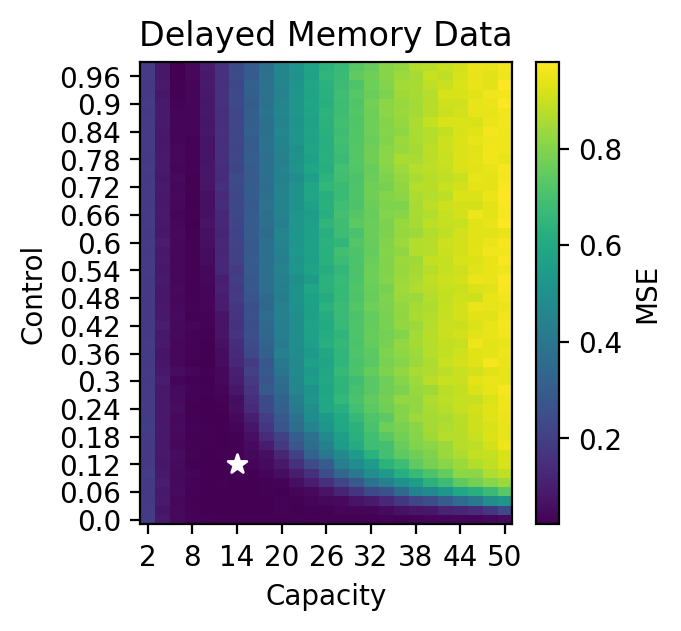

Dict{String, Matrix{Float64}} with 4 entries:
  "control_2"  => [0.641629 0.637988 0.635193; 0.529448 0.52474 0.522501]
  "no_control" => [0.655441 0.655441 0.655441; 0.533471 0.533471 0.533471]
  "control_1"  => [0.64231 0.64231 0.64231; 0.525258 0.525258 0.525258]
  "control_3"  => [0.640231 0.634705 0.63259; 0.523619 0.520579 0.519496]

In [ ]:
this_nt_per_sec = 400;
this_ms = .2;

this_mtx = Float64.(Matrix(matrices[this_nt_per_sec,this_ms][:,2:end]))
fig, ax = subplots(figsize=(3, 3), dpi = 200)
cax = ax.imshow(this_mtx, aspect="auto", cmap="viridis", origin="lower")

# Get labels for axes
x_labels = q_vals
y_labels = round.(1 .- eps_vals, digits = 2)

# Set axis labels
ax.set_xticks(0:3:length(x_labels)-1)
ax.set_xticklabels(x_labels[1:3:end])
ax.set_xlabel("Capacity")

ax.set_yticks(0:3:length(y_labels)-1)
ax.set_yticklabels(y_labels[1:3:end])
ax.set_ylabel("Control")

colorbar(cax, ax=ax, label="MSE")

# Find the index of the minimum distance value
min_idx = argmin(this_mtx)  # Finds linear index of min value
min_row, min_col = Tuple(CartesianIndices(this_mtx)[min_idx])  # Convert to (row, col)

ax.scatter(min_col, min_row, color="white", marker="*", s=50, label="Min Distance")

ax.set_title("Delayed Memory Data")

best_epsilon = eps_vals[min_row]
best_N_Quanta_w_control = q_vals[min_col]

# now get the lowest best_N_Quanta when eps_val = 1
best_N_Quanta_no_control = q_vals[argmin(this_mtx[findfirst(eps_vals .== 1.),:])]
best_no_control_params = Dict(
    "epsilon" => 1.,
    "N_Quanta" => best_N_Quanta_no_control,
    "NT_per_Second" => this_nt_per_sec,
    "mem_slope" => this_ms
)

# load corresponding data point
best_no_control_data = load_data_point(best_no_control_params)

best_N_Quanta_control_1 = q_vals[argmin(this_mtx[findfirst(eps_vals .== .9),:])]
best_conrol_1_params = Dict(
    "epsilon" => .9,
    "N_Quanta" => best_N_Quanta_control_1,
    "NT_per_Second" => this_nt_per_sec,
    "mem_slope" => this_ms
)
# load data point
best_control_1_data = load_data_point(best_conrol_1_params)

best_N_Quanta_control_2 = q_vals[argmin(this_mtx[findfirst(eps_vals .== .8),:])]
best_conrol_2_params = Dict(
    "epsilon" => .8,
    "N_Quanta" => best_N_Quanta_control_2,
    "NT_per_Second" => this_nt_per_sec,
    "mem_slope" => this_ms
)
# load data point
best_control_2_data = load_data_point(best_conrol_2_params)

best_N_Quanta_control_3 = q_vals[argmin(this_mtx[findfirst(eps_vals .== .7),:])]
best_conrol_3_params = Dict(
    "epsilon" => .7,
    "N_Quanta" => best_N_Quanta_control_3,
    "NT_per_Second" => this_nt_per_sec,
    "mem_slope" => this_ms
)
# load data point
best_control_3_data = load_data_point(best_conrol_3_params)

# place all params in a dictionary
best_dm_params = Dict(
    "no_control" => best_no_control_params,
    "control_1" => best_conrol_1_params,
    "control_2" => best_conrol_2_params,
    "control_3" => best_conrol_3_params
)

# place all data points in a dictionary
best_dm_data_points = Dict(
    "no_control" => best_no_control_data,
    "control_1" => best_control_1_data,
    "control_2" => best_control_2_data,
    "control_3" => best_control_3_data
)

In [128]:
# get number of dm datapoints

# get names of each key in best_dm_data_points
dm_datapoint_names = collect(keys(best_dm_data_points))

n_dm_data_points = length(best_dm_data_points)

4

In [129]:
collect(dm_datapoint_names)

4-element Vector{String}:
 "control_2"
 "no_control"
 "control_1"
 "control_3"

In [130]:
best_dm_data_points[dm_datapoint_names[1]]

2×3 Matrix{Float64}:
 0.641629  0.637988  0.635193
 0.529448  0.52474   0.522501

sys:1: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.


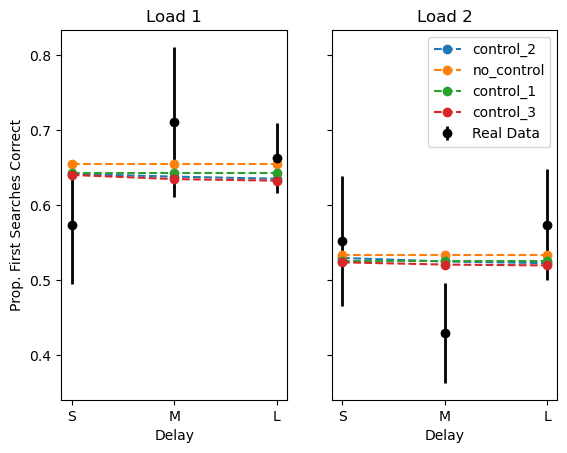

Python: <matplotlib.legend.Legend object at 0x340156b90>

In [131]:
# load the predictions for the control and no control case


n_dm_data_points = length(best_dm_data_points)

fig, ax = subplots(1,2, sharey=true)

# plot the real data


mean_perf_data

for i in 1:N_loads
    load = loads[i]
    load_data = mean_grouped_df[mean_grouped_df.load .== load, :]

    load_delays = convert(Vector{String}, string.(load_data.delay))

    # plot mean with error bars for sem
    ax[i-1].errorbar(load_delays, mean_perf_data[i,:], yerr=sem_grouped_df[sem_grouped_df.load .== load, :sem_n_searches], linestyle = "none", fmt="-o", color="black", linewidth=2, label = "Real Data")

    # plot each of the n_dm_datapoints
    for j in 1:n_dm_data_points
        this_name = dm_datapoint_names[j]
        ax[i-1].plot(load_delays, best_dm_data_points[this_name][i,:], "--o", label = this_name)
    end


    # ax[i-1].plot(load_delays, load_data.mean_n_searches, "-o", color="black", linewidth=2)
    ax[i-1].set_title("Load $load")
    ax[i-1].set_xlabel("Delay")
end
ax[0].set_ylabel("Prop. First Searches Correct")
ax[1].legend()



In [132]:
# create function to simulate retro-cure conditions
function simulate_retrocue(N_Object_Vals, N_Seconds_Pre_Vals, N_Seconds_Post_Vals, mem_slopes, N_Quanta, epsilon, NT_per_Sec; N_Trials = 1000)

    N_N_Object_vals = length(N_Object_Vals)
    N_mem_slopes = length(mem_slopes)
    N_N_Seconds_Pre_Vals = length(N_Seconds_Pre_Vals)
    N_N_Seconds_Post_Vals = length(N_Seconds_Post_Vals)

    # for post cue, always go to the end
    N_Seconds_Post = N_Seconds_Post_Vals[end]
    N_TimeSteps_Post = Int(ceil(N_Seconds_Post * NT_per_Sec))

    retro_cue_prob_correct = zeros(N_N_Object_vals, N_N_Seconds_Pre_Vals, N_N_Seconds_Post_Vals, N_mem_slopes)

    for N_Obj_idx = 1:N_N_Object_vals
        
        N_Objects = N_Object_Vals[N_Obj_idx]
        print(N_Objects)
        
        # loop through all pre-timepoints
        for N_Sec_Pre_idx = 1:length(N_Seconds_Pre_Vals)
            N_Seconds_Pre = N_Seconds_Pre_Vals[N_Sec_Pre_idx]
            N_TimeSteps_Pre = Int(round(N_Seconds_Pre * NT_per_Sec))
            Relevant_Timepoint = Int.(round.((N_Seconds_Pre .+  N_Seconds_Post_Vals).*NT_per_Sec))

            prob_correct = simulate_task_mult_ms(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post, N_Trials, simulate_retrocue_episode, Relevant_Timepoint; mem_slopes = mem_slopes, cue_reliability = 1, baseline_prob = .333)
                
            retro_cue_prob_correct[N_Obj_idx, N_Sec_Pre_idx, :, :] = prob_correct#[Relevant_Timepoint, 1, :]; # also only care about the first item
           #  GC.gc(true)

        end
    end

    return retro_cue_prob_correct

end

# create  function to simulate delayed forgetting conditions
function simulate_delayed_memory(N_Object_Vals, N_Seconds_NoCue, mem_slopes, N_Quanta, epsilon, NT_per_Sec; N_Trials = 1000)
    
    N_N_Object_vals = length(N_Object_Vals)
    N_N_Seconds_NoCue = length(N_Seconds_NoCue)
    N_mem_slopes = length(mem_slopes)

    delay_prob_correct = zeros(N_N_Object_vals, N_N_Seconds_NoCue, length(mem_slopes))

    for N_Obj_idx = 1:N_N_Object_vals

        # First we'll simulate the model without a retro-cue
    
        N_Objects = N_Object_Vals[N_Obj_idx]
        print(N_Objects)
        N_Seconds = N_Seconds_NoCue[end]
    
        N_TimeSteps_Pre = Int(round(N_Seconds * NT_per_Sec))
        N_TimeSteps_Post = 0
        Relevant_Timepoint = Int.(round.(N_Seconds_NoCue.*NT_per_Sec))

    
        # prob correct is Num Time Steps X Num Objects X Num Mem Slopes
        prob_correct = simulate_task_mult_ms(N_Quanta, N_Objects, epsilon, N_TimeSteps_Pre, N_TimeSteps_Post, N_Trials, simulate_delayed_memory_episode, Relevant_Timepoint; mem_slopes = mem_slopes, cue_reliability = 1, baseline_prob = .3333)
    
        delay_prob_correct[N_Obj_idx, : , :] = prob_correct#prob_correct[Relevant_Timepoint, 1, :];

        # GC.gc(true)

    end

    return delay_prob_correct

end


simulate_delayed_memory (generic function with 2 methods)

In [133]:
function make_retrocue_sims(these_params)

    N_Object_Vals = [2,3]

    N_Seconds_Pre_Vals = [5,7]
    N_Seconds_Post_Vals = [2,3,5]


    N_Quanta = these_params["N_Quanta"]
    epsilon = these_params["epsilon"]
    NT_per_Second = these_params["NT_per_Second"]
    mem_slope = these_params["mem_slope"]
    mem_slopes = [mem_slope]

    print(epsilon)

    retro_cue_prob_correct = simulate_retrocue(N_Object_Vals, N_Seconds_Pre_Vals, N_Seconds_Post_Vals, mem_slopes, N_Quanta, epsilon, NT_per_Second)

    return retro_cue_prob_correct

end

# make a function to simulate the delayed memory task
function make_delayed_memory_sims(these_params)

    N_Object_Vals = [2,3]
    N_Seconds_NoCue = [5,7,10]

    N_Quanta = these_params["N_Quanta"]
    epsilon = these_params["epsilon"]
    NT_per_Second = these_params["NT_per_Second"]
    mem_slope = these_params["mem_slope"]
    mem_slopes = [mem_slope]

    print(epsilon)

    delay_prob_correct = simulate_delayed_memory(N_Object_Vals, N_Seconds_NoCue, mem_slopes, N_Quanta, epsilon, NT_per_Second)

    return delay_prob_correct

end

#retro_cue_prob_correct_w_control = make_retrocue_sims(best_control_params)
#retro_cue_prob_correct_no_control = make_retrocue_sims(best_no_control_params)




make_delayed_memory_sims (generic function with 1 method)

In [134]:
# simulate retro-cue for each best dm param
retro_cue_prob_correct = Dict()

# for each value in names, run the simulation
for i in 1:n_dm_data_points
    this_name = dm_datapoint_names[i]
    print(this_name)
    retro_cue_prob_correct[this_name] = make_retrocue_sims(best_dm_params[this_name])
end



control_20.823no_control1.023control_10.923control_30.723

In [135]:

# simulate delayed memory for each best dm param
delay_prob_correct = Dict()
# for each value in names, run the simulation
for i in 1:n_dm_data_points
    this_name = dm_datapoint_names[i]
    print(this_name)
    delay_prob_correct[this_name] = make_delayed_memory_sims(best_dm_params[this_name])
end


control_20.823no_control1.023control_10.923control_30.723

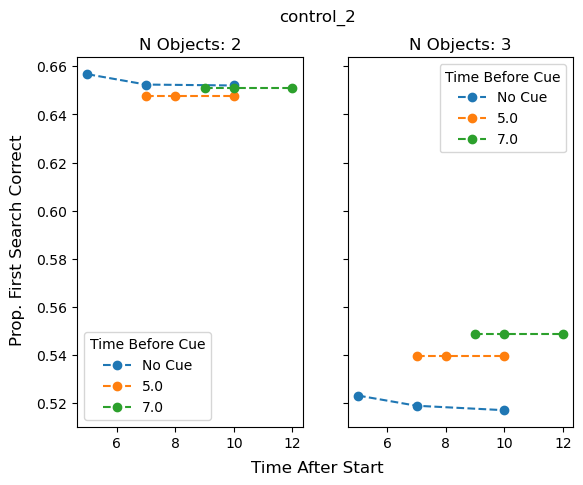

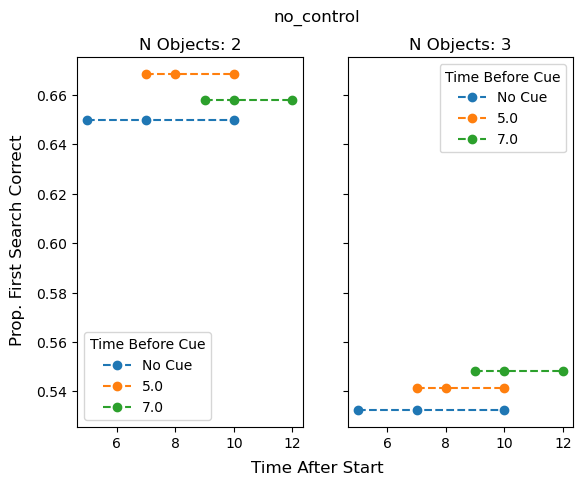

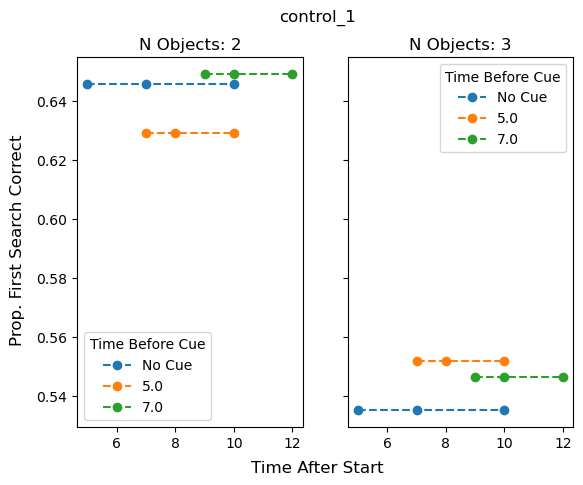

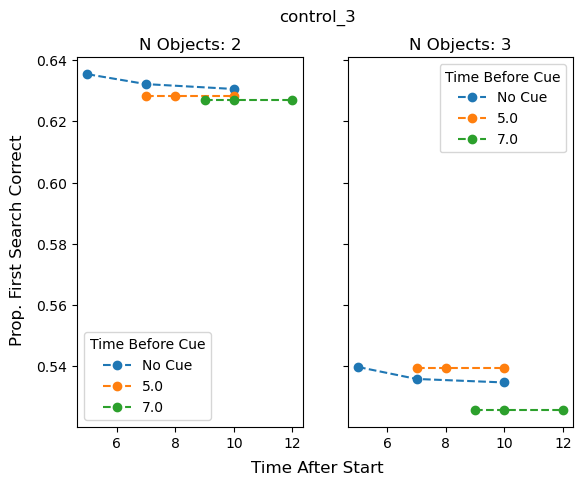

In [137]:


N_Seconds_Pre_Vals = [5,7]
N_Seconds_Post_Vals = [2,3,5]

for i = 1:N_dm_data_points
    fig,ax = subplots(1,2, sharey = true, sharex = true)

    this_name = dm_datapoint_names[i]
    this_retro_cue_prob_correct = retro_cue_prob_correct[this_name]
    this_delay_prob_correct = delay_prob_correct[this_name]

    for N_Obj_idx = 1:length(N_Object_Vals)
        ax[N_Obj_idx-1].plot(N_Seconds_NoCue, this_delay_prob_correct[N_Obj_idx,:], "--o", label = "No Cue")
        for N_Sec_Pre_idx = 1:length(N_Seconds_Pre_Vals)
                N_Seconds_Pre = N_Seconds_Pre_Vals[N_Sec_Pre_idx]

                ax[N_Obj_idx-1].plot(N_Seconds_Pre .+ N_Seconds_Post_Vals, this_retro_cue_prob_correct[N_Obj_idx, N_Sec_Pre_idx, :], "--o", label = "$(round(N_Seconds_Pre, digits = 2))")
                # ax[N_Obj_ids01].set_title("N Objects: $(N_Object_Vals[N_Obj_ids]), Pre: $(N_Seconds_Pre_Vals[N_Sec_Pre_idx]), Post: $(N_Seconds_Post_Vals[N_Sec_Post_idx])")
        end
        ax[N_Obj_idx-1].legend(title = "Time Before Cue")
        ax[N_Obj_idx-1].set_title("N Objects: $(N_Object_Vals[N_Obj_idx])")
    end
    fig.supylabel("Prop. First Search Correct")
    fig.supxlabel("Time After Start")
    fig.suptitle(this_name)
end

In [90]:
retro_cue_prob_correct

2×2×3×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.653834  0.641097
 0.525258  0.529503

[:, :, 2, 1] =
 0.653834  0.641097
 0.525258  0.529503

[:, :, 3, 1] =
 0.653834  0.641097
 0.525258  0.529503

In [ ]:
# make the above plot, but for each of the best dm params

fig,ax = subplots(1,2, sharey = true, sharex = true)


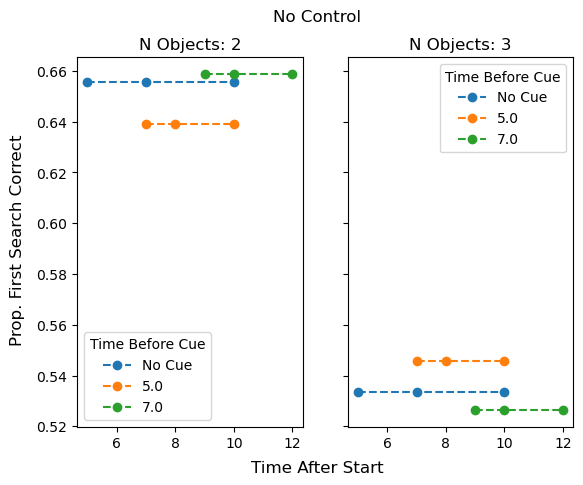

Python: Text(0.5, 0.98, 'No Control')

In [57]:
fig,ax = subplots(1,2, sharey = true, sharex = true)

retro_cue_prob_correct = retro_cue_prob_correct_no_control

N_Seconds_Pre_Vals = [5,7]
N_Seconds_Post_Vals = [2,3,5]

for N_Obj_idx = 1:length(N_Object_Vals)
    ax[N_Obj_idx-1].plot(N_Seconds_NoCue, best_no_control_data[N_Obj_idx,:], "--o", label = "No Cue")
    for N_Sec_Pre_idx = 1:length(N_Seconds_Pre_Vals)
            N_Seconds_Pre = N_Seconds_Pre_Vals[N_Sec_Pre_idx]

            ax[N_Obj_idx-1].plot(N_Seconds_Pre .+ N_Seconds_Post_Vals, retro_cue_prob_correct_no_control[N_Obj_idx, N_Sec_Pre_idx, :], "--o", label = "$(round(N_Seconds_Pre, digits = 2))")
            # ax[N_Obj_ids01].set_title("N Objects: $(N_Object_Vals[N_Obj_ids]), Pre: $(N_Seconds_Pre_Vals[N_Sec_Pre_idx]), Post: $(N_Seconds_Post_Vals[N_Sec_Post_idx])")
    end
    ax[N_Obj_idx-1].legend(title = "Time Before Cue")
    ax[N_Obj_idx-1].set_title("N Objects: $(N_Object_Vals[N_Obj_idx])")
end
fig.supylabel("Prop. First Search Correct")
fig.supxlabel("Time After Start")
fig.suptitle("No Control")

In [175]:
load_data = mean_grouped_df[mean_grouped_df.load .== 1, :]


Row,delay,load,mean_n_searches
,Cat…,Int64,Float64
1,S,1,0.574074
2,M,1,0.711111
3,L,1,0.662963
